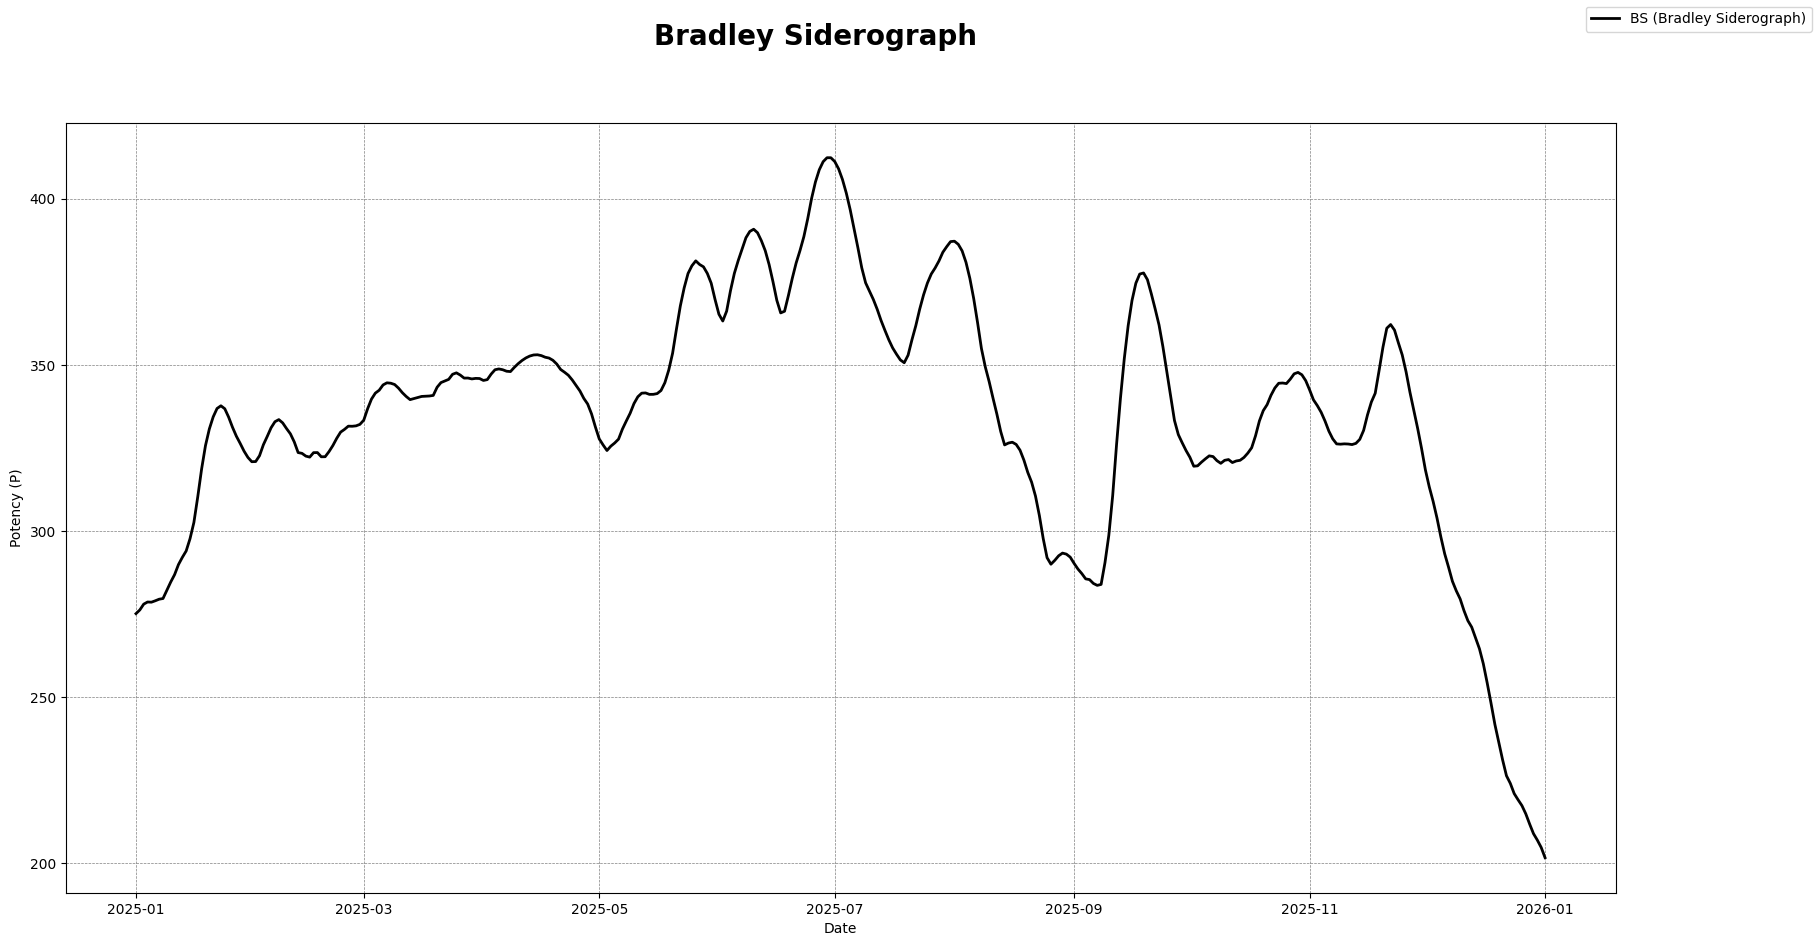

In [1]:
#!/usr/bin/env python
# coding: utf-8

# =================================================================================================
#  BRADLEY-STYLE SIDEROGRAPH  ─  PYTHON IMPLEMENTATION
#
#  References
#  ----------
#  • Donald A. Bradley, “Stock-Market Prediction, The Planetary Barometer” (Llewellyn, 1950/1984).
#      •  p.24  – Figure 6, sine-curve weighting for 15° orbs               (amplitude = 10 → 0)
#      •  p.26  – Figure 7, Valency of Conjunctions                         (+ / – sign table)
#      •  p.30  – Figure 8, combination of M, L and D factors → P           (P = M + 4 (L + D))
#      •  p.34  – Figure 10, example graph of P plotted against the Dow     (the “Siderograph”)
#
#  This file reproduces Bradley’s algorithm and extends it with heliocentric
#  and planetocentric reference frames.  The only dependency that is not in the
#  Python standard library is `pyswisseph`, a thin wrapper around the Swiss Ephemeris.
#  ---------------------------------------------------------------------------------
#  pip install --user pyswisseph
# =================================================================================================
import os
# path to binary ephemeris data files
# for download info: https://www.astro.com/ftp/swisseph/ephe/
# os.environ['SE_EPHE_PATH'] = '/path/to/swisseph/ephe/' # User needs to set this path if ephemeris files are not in default location

import swisseph as swe                 # Swiss Ephemeris (astronomical calculations)
import datetime                        # Handling civil calendar dates
from typing import Dict, List, Tuple   # Type hinting for better code readability
import numpy as np                     # Vectorised arithmetic for numerical operations
import matplotlib.pyplot as plt        # Plotting the final graph
import pandas as pd                    # Tabular data storage/manipulation (DataFrames)
from itertools import combinations     # To list every 2-planet pair efficiently
from functools import reduce           # Functional “fold” for influence summing
import re                              # Fast regex search for column names
import math                            # Mathematical functions (e.g., cos, radians)


# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------
#  REFERENCE FRAME
#  ---------------
#  Bradley worked exclusively with apparent geocentric positions.  The two extra
#  options below allow researchers to replicate heliocentric (Sun-centred) or
#  planetocentric (any planet used as the centre) work for comparative studies.
# ---------------------------------------------------------------------------------
center = 'geocentric' # Defaulting to geocentric as per Bradley's original method
# center = 'heliocentric' # Option for Sun-centered calculations (ignored for this review)
# center = 'planetocentric' # Option for planet-centered calculations (ignored for this review)
center_planet = swe.EARTH # Only used when center == 'planetocentric'

# ---------------------------------------------------------------------------------
#  PLANET PAIRS (page-terminology)
#  -------------------------------
#  Bradley divides pairs into
#      • “middle terms”  (p.13 & p.16)     → faster synods, 0.2 – 3 years
#      • “long  terms”   (p.14 & Table II) → slow synods, 12 – 492 years
#  The two lists below are the exact same pairs highlighted in the booklet.
# ---------------------------------------------------------------------------------
# Define lists of planet pairs considered as "middle terms" by Bradley.
# These pairs have relatively shorter synodic cycles.
mid_term_combinations = [
    ('Mercury','Pluto'), ('Mercury','Neptune'), ('Mercury','Uranus'),
    ('Mercury','Saturn'),('Mercury','Jupiter'), ('Mercury','Mars'),
    ('Mercury','Sun'),   ('Mercury','Venus'),
    ('Venus','Pluto'),   ('Venus','Neptune'),  ('Venus','Uranus'),
    ('Venus','Saturn'),  ('Venus','Jupiter'),  ('Venus','Mars'),
    ('Sun','Pluto'),     ('Sun','Neptune'),    ('Sun','Uranus'),
    ('Sun','Saturn'),    ('Sun','Jupiter'),    ('Sun','Venus'),
    ('Mars','Pluto'),    ('Mars','Neptune'),   ('Mars','Uranus'),
    ('Mars','Saturn'),   ('Mars','Sun'),       ('Mars','Jupiter')
]

# Define lists of planet pairs considered as "long terms" by Bradley.
# These pairs have significantly longer synodic cycles.
long_term_combinations = [
    ('Jupiter','Pluto'), ('Jupiter','Neptune'), ('Jupiter','Uranus'),
    ('Jupiter','Saturn'),('Saturn','Pluto'),    ('Saturn','Neptune'),
    ('Saturn','Uranus'), ('Uranus','Pluto'),    ('Uranus','Neptune'),
    ('Neptune','Pluto')
]

# ---------------------------------------------------------------------------------
#  VALENCY  (p.26, Fig.7)
#  ----------------------
#  A conjunction (0°) can be bullish or bearish depending on the planets involved.
#  Bradley summarised the sign convention in a 10×10 matrix, reproduced verbatim
#  below (+1 = “plus”/bullish, –1 = “minus”/bearish).
# ---------------------------------------------------------------------------------
# This matrix represents Bradley's valency table (Figure 7 from the book).
# It determines whether a conjunction between two planets is considered positive (+1) or negative (-1).
valency_data = [
    # Rows: Moon, Sun, Mercury, Venus, Mars, Jupiter, Saturn, Uranus, Neptune, Pluto
    # Columns: Moon, Sun, Mercury, Venus, Mars, Jupiter, Saturn, Uranus, Neptune, Pluto
    [ 1,  1,  1,  1, -1,  1, -1, -1,  1, -1],  # moon with (moon … pluto)
    [ 1,  1,  1,  1, -1,  1, -1,  1, -1, -1],  # sun
    [ 1,  1,  1,  1, -1,  1, -1,  1,  1, -1],  # mercury
    [ 1,  1,  1,  1, -1,  1, -1,  1,  1,  1],  # venus
    [-1, -1, -1, -1,  1, -1, -1, -1, -1, -1],  # mars
    [ 1,  1,  1,  1, -1,  1, -1, -1,  1, -1],  # jupiter
    [-1, -1, -1, -1, -1, -1,  1, -1, -1, -1],  # saturn
    [-1,  1,  1,  1, -1, -1, -1,  1, -1, -1],  # uranus
    [ 1, -1,  1,  1, -1,  1, -1, -1,  1, -1],  # neptune
    [-1, -1, -1,  1, -1, -1, -1, -1, -1,  1],  # pluto
]
# Create a Pandas DataFrame for easy lookup of valency values.
# Index and columns are planet names for intuitive access (e.g., valency.loc['sun', 'mars']).
valency = pd.DataFrame(
    valency_data,
    index    =["moon","sun","mercury","venus","mars","jupiter","saturn","uranus","neptune","pluto"],
    columns  =['moon','sun','mercury','venus','mars','jupiter','saturn','uranus','neptune','pluto']
)

# ---------------------------------------------------------------------------------
#  MASTER PLANET LIST
#  ------------------
#  Bradley ignores Earth (because geocentric), uses everything else that was
#  discoverable at the time (Pluto included).  Moon is optional in many implementations
# ---------------------------------------------------------------------------------
# Define the list of celestial bodies used in the calculations.
# These correspond to Swiss Ephemeris integer constants.
planets = [
    swe.SUN, swe.MOON, swe.MERCURY, swe.VENUS, swe.MARS,
    swe.JUPITER, swe.SATURN, swe.URANUS, swe.NEPTUNE, swe.PLUTO
]

# planets = [swe.VENUS, swe.URANUS] # Example of a reduced list for testing specific pairs
# planets = [swe.MERCURY, swe.VENUS, swe.MARS, swe.JUPITER, swe.SATURN, swe.URANUS, swe.NEPTUNE, swe.PLUTO] # Excluding Sun and Moon
# planets = [swe.SUN, swe.MERCURY, swe.VENUS, swe.MARS, swe.JUPITER, swe.SATURN, swe.URANUS, swe.NEPTUNE, swe.PLUTO] # Excluding Moon

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_julian_day(date: datetime.date) -> float:
    """
    Convert a calendar date (year, month, day) to Julian Day Number.
    The Swiss Ephemeris library primarily works with Julian Days for time.
    """
    return swe.julday(date.year, date.month, date.day)


def generate_dates(start_date: datetime.date, end_date: datetime.date) -> List[datetime.date]:
    """
    Generates a list of dates from start_date to end_date, inclusive.
    Helpful for iterating through a specific time period day by day.
    """
    delta = end_date - start_date # Calculate the total number of days in the range.
    # Loop from 0 to delta.days (inclusive) to generate each date in the range.
    return [start_date + datetime.timedelta(days=i) for i in range(delta.days + 1)]

def calculate_julian_days(start_date: datetime.date,
                          end_date  : datetime.date) -> Dict[datetime.date,float]:
    """
    Creates a dictionary mapping each calendar date in a range to its Julian Day Number.
    This provides a quick lookup for JD values needed for ephemeris calculations.
    """
    dates = generate_dates(start_date, end_date) # Generate all dates in the specified range.
    # For each date, calculate its Julian Day and store it in the dictionary.
    # This is a dictionary comprehension for concise creation.
    return {d: calculate_julian_day(d) for d in dates}


#  Example: one civil year
# Define the start and end dates for the Siderograph calculation period.
start_date, end_date = datetime.date(2025,1,1), datetime.date(2026,1,1)

# Calculate Julian Days for the defined date range.
julian_days = calculate_julian_days(start_date, end_date)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_planetary_longitudes(jd  : float,
                                   mode: str='geocentric') -> Dict[str,float]:
    """
    Return longitudes of all planets for a given Julian Day (jd).
    The 'mode' parameter defaults to 'geocentric' as per Bradley's method.
    Swiss Ephemeris flag construction:
        • FLG_SWIEPH      – main algorithm for Swiss Ephemeris
        • FLG_SIDEREAL    – Bradley worked in sidereal zodiac (positions relative to fixed stars)
        • FLG_EQUATORIAL  – not used here for longitude (λ is ecliptic longitude)
        • optional flags  – HELCTR (heliocentric), or planetocentric handled via swe.calc_pctr (ignored for this review)
    """
    def get_longitude(planet_id): # Changed 'planet' to 'planet_id' for clarity, as 'planet' is a swe constant
        """Helper function to calculate longitude for a single planet."""
        # Based on the specified mode (geocentric, heliocentric, planetocentric),
        # use the appropriate Swiss Ephemeris function and flags.
        # For this review, we primarily focus on the 'geocentric' case.
        if mode == 'geocentric':
            # swe.calc_ut calculates positions for a universal time (jd).
            # FLG_SWIEPH uses the full Swiss Ephemeris precision.
            # FLG_SIDEREAL specifies that sidereal longitudes are required.
            pos, _ = swe.calc_ut(jd, planet_id, flags=swe.FLG_SWIEPH | swe.FLG_SIDEREAL)
        elif mode == 'heliocentric': # This block is ignored for the current review focus
            pos, _ = swe.calc_ut(jd, planet_id, flags=swe.FLG_SWIEPH | swe.FLG_SIDEREAL | swe.FLG_HELCTR)
        elif mode == 'planetocentric': # This block is ignored for the current review focus
            if planet_id == center_planet: # A planet has 0° longitude from itself
                return {} # Return empty dict if the planet is the center (to avoid errors/meaningless data)
            pos, _ = swe.calc_pctr(jd, planet_id, center=center_planet,
                                  flags=swe.FLG_SWIEPH | swe.FLG_SIDEREAL)
        else:
            raise ValueError("mode must be 'geocentric', 'heliocentric', or 'planetocentric'")
        # Return a dictionary with the planet's name and its calculated longitude.
        # pos[0] contains the ecliptic longitude.
        return {f"{swe.get_planet_name(planet_id)}_Longitude": pos[0]}

    # Use a dictionary comprehension to apply get_longitude to all planets in the 'planets' list.
    # This flattens the list of dictionaries (one per planet) into a single dictionary.
    return {k: v for d in map(get_longitude, planets) for k, v in d.items()}


def calculate_all_longitudes(jd_map: Dict[datetime.date,float],
                             mode  : str='geocentric')\
                             -> Dict[datetime.date,Dict[str,float]]:
    """
    Wrapper function to calculate planetary longitudes for all dates in the jd_map.
    Iterates over each date and its corresponding Julian Day.
    The result is a dictionary where keys are dates and values are dictionaries of planetary longitudes for that date.
    """
    # This is a dictionary comprehension. For each date and its Julian Day (jd) in jd_map:
    # call calculate_planetary_longitudes to get the longitudes for that jd.
    return {date: calculate_planetary_longitudes(jd, mode) for date, jd in jd_map.items()}


# Calculate the geocentric longitudes for all planets for each day in the specified range.
planetary_longitudes = calculate_all_longitudes(julian_days, mode=center)

# Convert the dictionary of longitudes into a Pandas DataFrame for easier manipulation and analysis.
# 'orient="index"' means dictionary keys (dates) become the DataFrame index.
df_planetary_longitudes = pd.DataFrame.from_dict(planetary_longitudes, orient='index')
df_planetary_longitudes.index.name = 'timestamp' # Name the index column.
df_planetary_longitudes.reset_index(inplace=True) # Convert the index (dates) into a regular column.
df_planetary_longitudes.set_index('timestamp', inplace=True) # Set 'timestamp' (dates) back as the index. This is a common pattern.

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_planetary_declinations(jd  : float,
                                     mode: str='geocentric') -> Dict[str,float]:
    """
    Calculate declinations for Venus and Mars, as required for Bradley’s D-factor.
    D-factor is ½ the algebraic sum of Venus and Mars declinations
    (positive = north, negative = south).
    The function remains generic for experimentation but defaults to Venus and Mars.
    For declinations, FLG_EQUATORIAL is used instead of FLG_SIDEREAL for longitude.
    """
    # Bradley's D-factor specifically uses Venus and Mars.
    subset = [swe.VENUS, swe.MARS]

    def get_dec(planet_id): # Changed 'planet' to 'planet_id'
        """Helper function to calculate declination for a single planet."""
        if mode == 'geocentric':
            # FLG_EQUATORIAL is used for equatorial coordinates (Right Ascension, Declination).
            # Declination is pos[1].
            pos, _ = swe.calc_ut(jd, planet_id, flags=swe.FLG_SWIEPH | swe.FLG_EQUATORIAL | swe.FLG_SIDEREAL)
        elif mode == 'heliocentric': # Ignored for this review
            pos, _ = swe.calc_ut(jd, planet_id, flags=swe.FLG_SWIEPH | swe.FLG_EQUATORIAL | swe.FLG_SIDEREAL | swe.FLG_HELCTR)
        elif mode == 'planetocentric': # Ignored for this review
            if planet_id == center_planet:
                return {}
            pos, _ = swe.calc_pctr(jd, planet_id, center=center_planet,
                                  flags=swe.FLG_SWIEPH | swe.FLG_EQUATORIAL | swe.FLG_SIDEREAL)
        else:
            # Basic error handling for invalid mode.
            raise ValueError("mode must be 'geocentric', 'heliocentric', or 'planetocentric'")
        # Return a dictionary with the planet's name and its calculated declination.
        return {f"{swe.get_planet_name(planet_id)}_Declination": pos[1]} # pos[1] is declination

    # Apply get_dec to the subset of planets (Venus and Mars) and combine results.
    return {k: v for d in map(get_dec, subset) for k, v in d.items()}


def calculate_all_declinations(jd_map: Dict[datetime.date,float], mode='geocentric'): # Added type hint for jd_map
    """
    Wrapper to calculate Venus and Mars declinations for all dates in jd_map.
    """
    # Similar to calculate_all_longitudes, this iterates through dates to get declinations.
    return {date: calculate_planetary_declinations(jd, mode) for date, jd in jd_map.items()}

# Calculate the geocentric declinations for Venus and Mars for each day.
planetary_declinations = calculate_all_declinations(julian_days, mode=center)

# Convert to DataFrame format for consistency and ease of use.
df_planetary_declinations = pd.DataFrame.from_dict(planetary_declinations, orient='index')
df_planetary_declinations.index.name = 'timestamp'
df_planetary_declinations.reset_index(inplace=True)
df_planetary_declinations.set_index('timestamp', inplace=True)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Import math and combinations again (already imported at the top, but harmless)
# import math
# from itertools import combinations
# import pandas as pd # Already imported

# ──────────────────────────────────────────────────────────────────────────────
# Geometry helper
# ──────────────────────────────────────────────────────────────────────────────
def angular_sep(lon1: float, lon2: float) -> float:
    """
    Return the *smallest* angular distance between two ecliptic longitudes.
    Longitudes are in degrees and can be any range (e.g., 0-360 or -180 to 180).
    The result is always in the range 0 – 180 degrees.

    Parameters
    ----------
    lon1, lon2 : float
        Sidereal (or tropical) longitudes in **degrees**.

    Returns
    -------
    float
        The acute separation in the closed interval 0 – 180 degrees.

    Notes
    -----
    •  Because longitudes wrap every 360 °, the separation between 10 ° and
       350 ° is 20 °, not 340 °.
    •  The modulo‑arithmetic trick below puts the difference into 0 – 360;
       if it lands on the “far side” (> 180 °) we mirror it to obtain the
       shorter arc.
    """
    d = (lon2 - lon1) % 360.0 # Calculate difference and normalize to 0-360 range.
    # If the difference 'd' is greater than 180, it means the shorter arc is 360 - d.
    # Otherwise, 'd' is already the shorter arc.
    return d if d <= 180.0 else 360.0 - d


# ──────────────────────────────────────────────────────────────────────────────
# Aspect‑matrix builder
# ──────────────────────────────────────────────────────────────────────────────
def create_aspect(
    aspect: int,                 # The specific aspect angle (e.g., 0 for conjunction, 90 for square)
    longitudes: pd.DataFrame,    # DataFrame of daily planetary longitudes
    valency: pd.DataFrame        # DataFrame containing valency signs for conjunctions
) -> pd.DataFrame:
    """
    Compute Bradley amplitudes for *one* specific aspect (e.g., 0°, 60°) across all planet pairs.
    This function calculates the "strength" or "influence" of this aspect for each pair on each day.

    Parameters
    ----------
    aspect : int
        Central angle of the aspect (0, 60, 90, 120, 180).
    longitudes : pd.DataFrame
        Index   → dates (or Julian days)
        Columns → '<planet>_Longitude' (e.g. 'Mars_Longitude').
        Values  → longitude in **degrees** for that epoch.
    valency : pd.DataFrame
        +1/‑1 sign table from Bradley Figure 7.
        Both index *and* columns must be lower‑case planet names.

    Returns
    -------
    pd.DataFrame
        Each column represents the amplitude time‑series for a unique planet pair
        at the requested aspect (e.g. sun_mars_90). Index matches input 'longitudes'.
    """

    # ── Inner helper function: scalar amplitude for *one* epoch (day) & *one* planet pair ──
    def calc_amplitude(sep: float, p1_name: str, p2_name: str) -> float: # Renamed p1, p2 to p1_name, p2_name
        """
        Maps an exact angular separation between two planets to a weighted amplitude,
        following Bradley's Figure 6 (sine-curve weighting for 15° orbs).

        • Outside the ±15 ° orb from the exact aspect angle → amplitude is 0.0.
        • Inside the orb → amplitude is 10 × cosine‑drop‑off (scaled from 10 at exact aspect to 0 at orb limit).
        • If the aspect is a conjunction (0 °), apply the +/‑ sign from Bradley's valency table.
        """
        # Calculate how far the actual separation ('sep') is from the ideal aspect angle.
        delta = abs(sep - aspect) # 'aspect' is from the outer function's scope

        # If the deviation 'delta' is greater than the allowed orb of 15 degrees, the aspect has no influence.
        if delta > 15:
            return 0.0

        # Cosine curve weighting: Amplitude is 10 at exact aspect (delta=0)
        # and drops to 0 when delta reaches 15 degrees.
        # math.radians converts degrees to radians for math.cos().
        # (delta * 90 / 15) scales delta from 0-15 range to 0-90 range for the cosine curve.
        amp = 10.0 * math.cos(math.radians(delta * 6.0)) # Simplified: 90/15 = 6

        # Apply Bradley’s valency (sign) only for conjunctions (0-degree aspect).
        if aspect == 0:
            # Look up the valency using lowercase planet names (as per valency DataFrame).
            amp *= valency.at[p1_name.lower(), p2_name.lower()]

        return amp

    # ── Build a DataFrame column for every unordered planet pair ──
    frames = [] # List to store Series (columns) for each planet pair.
    # Iterate through all unique combinations of 2 planets from the longitude columns.
    # 'longitudes.columns' gives ['Sun_Longitude', 'Moon_Longitude', ...].
    # combinations() ensures each pair is processed once (e.g., (Sun, Moon) but not (Moon, Sun) again).
    for c1_col_name, c2_col_name in combinations(longitudes.columns, 2): # c1, c2 are column names like 'Mars_Longitude'
        # Extract planet names (e.g., 'sun', 'mars') from column names (e.g., 'Sun_Longitude').
        # Assumes column names are in the format 'PlanetName_Longitude'.
        p1_name_extracted, p2_name_extracted = c1_col_name.split('_')[0], c2_col_name.split('_')[0]
        # Create a unique column name for this pair and aspect (e.g., 'sun_mars_0').
        colname = f"{p1_name_extracted}_{p2_name_extracted}_{aspect}"

        # Vectorised operation over rows of the longitudes DataFrame:
        # For each row (each day):
        #   1. Get the longitudes of planet 1 (row[c1_col_name]) and planet 2 (row[c2_col_name]).
        #   2. Calculate their angular separation using angular_sep().
        #   3. Pass this separation and planet names to calc_amplitude() to get the aspect's strength for that day.
        # The result 'series' is a Pandas Series where the index is dates and values are amplitudes.
        series = longitudes.apply(
            lambda row: calc_amplitude(
                angular_sep(row[c1_col_name], row[c2_col_name]), # Current separation for this pair on this day
                p1_name_extracted, p2_name_extracted                  # Names for valency lookup
            ),
            axis=1 # Apply function row-wise
        )
        frames.append(series.rename(colname)) # Add the resulting Series (column) to our list.

    # Concatenate all individual pair-aspect Series into a single DataFrame.
    # Each Series becomes a column in the new DataFrame.
    return pd.concat(frames, axis=1)


# Define the major aspect angles Bradley considered.
aspect_angles = [0, 60, 90, 120, 180] # Conjunction, Sextile, Square, Trine, Opposition

# Calculate aspect influences for all defined aspect angles.
# This involves a loop (list comprehension) that calls create_aspect() for each angle.
# The results (DataFrames for each aspect angle) are then concatenated column-wise.
# df_all_aspects will have columns like 'Sun_Mars_0', 'Sun_Mars_60', 'Venus_Jupiter_90', etc.
df_all_aspects = pd.concat(
    [create_aspect(a, df_planetary_longitudes, valency) for a in aspect_angles],
    axis=1 # Concatenate along columns
)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_influence_vectorized(df_aspects: pd.DataFrame,       # DataFrame of all pair-aspect influences
                                   pairs: List[Tuple[str,str]]) -> pd.Series: # List of specific planet pairs (e.g., mid_term_combinations)
    """
    Sums the amplitudes of all aspects for a given list of planet pairs.
    For each pair in the 'pairs' list (e.g., ('Mercury','Jupiter')), this function finds all columns in 'df_aspects'
    that match that pair across all aspect angles (e.g., 'Mercury_Jupiter_0', 'Mercury_Jupiter_60', etc.)
    and sums their daily values.
    This yields a daily time-series representing either Bradley’s M (middle terms) or L (long terms) factor.
    """

    def cols_for_pair(pair: Tuple[str,str]): # Renamed 'pair' from outer scope for clarity
        """
        Helper function to find all column names in df_aspects that correspond to a given planet pair.
        Example: for pair ('Mercury', 'Jupiter'), it looks for columns matching "Mercury_Jupiter_\\d+"
        (e.g., Mercury_Jupiter_0, Mercury_Jupiter_60, etc.) and also "Jupiter_Mercury_\\d+"
        to handle both orderings as combinations() in create_aspect might produce either.
        """
        # Create regex patterns to match column names for the pair in both orders.
        # E.g., "Mercury_Jupiter_\\d+" or "Jupiter_Mercury_\\d+"
        # \\d+ matches one or more digits (the aspect angle).
        # re.IGNORECASE can be useful if planet name casing varies, but current setup is consistent.
        pattern1_str = f"{pair[0]}_{pair[1]}_\\d+"
        pattern2_str = f"{pair[1]}_{pair[0]}_\\d+"
        
        # Find columns matching the first pattern
        cols1 = df_aspects.columns[df_aspects.columns.str.contains(pattern1_str, regex=True, case=False)] # Using contains for flexibility
        # Find columns matching the second pattern
        cols2 = df_aspects.columns[df_aspects.columns.str.contains(pattern2_str, regex=True, case=False)]
        
        # Combine the unique column names from both patterns
        return df_aspects.columns.intersection(cols1.union(cols2))


    # Start with a Series of zeros, with the same index as df_aspects (dates).
    # This will be our accumulator for the total influence.
    # The 'reduce' function applies a rolling computation.
    # It iterates through each 'pair' in the 'pairs' list (e.g., mid_term_combinations).
    # For each pair:
    #   1. 'cols_for_pair(pair)' gets all relevant columns from df_aspects.
    #   2. 'df_aspects[selected_cols].sum(axis=1)' sums the influences across these aspects for each day.
    #   3. 'acc.add(..., fill_value=0)' adds this sum to the accumulator.
    # The result is a single Series representing the total daily influence (M or L).
    
    # Initialize an accumulator Series with zeros, matching the index of df_aspects.
    total_influence_sum = pd.Series(0.0, index=df_aspects.index, dtype=float)

    # Loop through each pair defined in the 'pairs' list (e.g., mid_term_combinations)
    for current_pair in pairs:
        # Get the column names from df_aspects that correspond to this current_pair for any aspect angle
        relevant_columns = cols_for_pair(current_pair)
        
        # If there are any relevant columns found for this pair
        if not relevant_columns.empty:
            # Sum the values in these columns for each row (day)
            # This gives the total aspect strength for this specific pair across all its aspects for each day
            pair_daily_sum = df_aspects[relevant_columns].sum(axis=1)
            
            # Add this pair's daily sum to the overall total influence sum
            total_influence_sum = total_influence_sum.add(pair_daily_sum, fill_value=0)
            
    return total_influence_sum

# The original reduce version:
# return reduce(
# lambda acc, current_pair_from_map: acc.add(df_aspects[cols_for_pair(current_pair_from_map)].sum(axis=1), fill_value=0),
# pairs, # Iterate over the list of pairs
# pd.Series(0.0, index=df_aspects.index, dtype=float) # Initial accumulator
# )


# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_p(df_aspects         : pd.DataFrame,      # DataFrame of all pair-aspect influences
                mid_pairs          : List[Tuple[str,str]], # List of "middle term" planet pairs
                long_pairs         : List[Tuple[str,str]], # List of "long term" planet pairs
                declinations_df    : pd.DataFrame) -> pd.Series: # DataFrame of Venus and Mars declinations
    """
    Calculates the final Bradley Siderograph value (P) by combining the three components: M, L, and D.
    The formula from Bradley's book (p.30, Figure 8) is P = M + X * (L + D).

        M = Sum of influences from "middle term" pairs.
        L = Sum of influences from "long term" pairs.
        D = ½ * (Venus Declination + Mars Declination). (Bradley's D-factor)
            The book uses ½ of sum; the code implements this.
        X = 4 (Amplification factor used by Bradley).
    """
    # Calculate M: Sum of influences from all aspects of middle-term pairs.
    M = calculate_influence_vectorized(df_aspects, mid_pairs)
    # Calculate L: Sum of influences from all aspects of long-term pairs.
    L = calculate_influence_vectorized(df_aspects, long_pairs)
    
    # Calculate D: The declination factor.
    # Sum the declinations of Venus and Mars for each day (axis=1 sums across columns for each row/day).
    # Then multiply by 0.5 as per Bradley's method for the D factor.
    # Declinations are already algebraic (North positive, South negative).
    D = 0.5 * declinations_df.sum(axis=1)

    # Bradley's amplification factor for L and D.
    X = 4
    
    # Calculate the final Potency (P) value for each day.
    P_series = M + X * (L + D)
    P_series.name = 'P_Value' # Give a name to the resulting Series
    return P_series


# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Calculate the final Siderograph "P" value for each day in the analysis period.
P = calculate_p(df_all_aspects,
                mid_term_combinations,       # Using the predefined list of middle term pairs
                long_term_combinations,      # Using the predefined list of long term pairs
                df_planetary_declinations)   # Using the calculated Venus/Mars declinations

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plotting the calculated Bradley Siderograph (P value) over time.

# Create a figure and an axes object for the plot.
# figsize controls the dimensions of the plot.
fig, ax = plt.subplots(figsize=(20,10))

# Plot the P values. 'lw' is line width. 'label' is for the legend.
ax.plot(P.index, P.values, lw=2, color='black', label='BS (Bradley Siderograph)') # Explicitly plot P.index and P.values

# Set the label for the Y-axis.
ax.set_ylabel("Potency (P)", color='black')
# Set the label for the X-axis (optional, often inferred from data type).
ax.set_xlabel("Date")

# Set the main title for the plot.
fig.suptitle("Bradley Siderograph", fontsize=20, fontweight='bold')

# Add a cosmetic grid to the plot for better readability.
ax.grid(True, linewidth=.5, linestyle='--', color='gray')

# Add a legend to the plot, positioned in the upper right.
fig.legend(loc='upper right')

# Save the plot as a PNG image file.
# dpi sets the resolution. bbox_inches='tight' tries to fit everything neatly.
plt.savefig('Bradley-Siderograph.png', dpi=300, bbox_inches='tight')

# Display the plot.
plt.show()

